In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!python /content/drive/MyDrive/SGID-PFF/code/inference.py --quick_test 'SOTS_indoor'


mkdir: ../infer_results
mkdir: ../infer_results/infer_SOTS_indoor
mkdir: ../infer_results/infer_SOTS_indoor/inference_image_2022-12-09 15-09-11
Inference - SOTS_indoor
save_image: True
data_path: /content/drive/MyDrive/rse_rl/example_data/SOTS/indoor/hazy
gt_path: /content/drive/MyDrive/rse_rl/example_data/SOTS/indoor/clear
model_path: /content/drive/MyDrive/SGID-PFF/pretrained_models/SOTS_indoor.pt
result_path: ../infer_results/infer_SOTS_indoor
size_must_mode: 4
device: cuda
Creating Dehaze-SGID-PFF Net
Creating Pre-Dehaze-T Net
Creating Trans Net
Creating U-Net
Creating Dehaze-T Net
Creating BRB-Fusion-Module
Creating Trans Net
Creating U-Net
Loading model from /content/drive/MyDrive/SGID-PFF/pretrained_models/SOTS_indoor.pt
> 1400_1 PSNR=38.128, SSIM=0.9939 pre_time:0.907s, forward_time:7.686s, post_time:0.738s, total_time:9.331s
> 1400_10 PSNR=37.130, SSIM=0.9875 pre_time:0.949s, forward_time:0.063s, post_time:0.700s, total_time:1.712s
> 1400_2 PSNR=37.041, SSIM=0.9867 pre_time:0.

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/SGID-PFF/code')

In [5]:
!pip install torch
!pip install torchsummary
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 170 kB 4.9 MB/s 
     |████████████████████████████████| 1.5 MB 58.5 MB/s 
     |████████████████████████████████| 237 kB 88.0 MB/s 
     |████████████████████████████████| 1.6 MB 79.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 8.5 MB/s 
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616822 sha256=29133771d54d96aeac73c56376858b02706944a52e5d196886ece1e8cfad3825
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441028 sha256=3c9d03fbd6a7301cf0c532b9df4c63036ddbd13974767f738f2090a9c43945c0
  Stored in directory: /root/.cache/pip/whe

In [7]:
import stable_baselines3

In [8]:
import torch
from torchvision import models
from torchsummary import summary
import model
from  model.dehaze_sgid_pff import DEHAZE_SGID_PFF
import numpy as np
import tensorflow as tf
import glob
import cv2
import torchvision
import matplotlib.pyplot as plt
import gym
from gym import spaces
from stable_baselines3 import A2C
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv

In [ ]:
# import stable_baselines3

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [10]:
import torch
torch.cuda.empty_cache()

In [11]:
PATH = "/content/drive/MyDrive/SGID-PFF/pretrained_models/SOTS_indoor.pt"


In [36]:
model = DEHAZE_SGID_PFF(img_channels=3, t_channels=1, n_resblock=3, n_feat=32).to(device)
model.load_state_dict(torch.load(PATH),strict=False)
strr = 'dehaze.trans_net.unet_body.outBlock.'
action = torch.from_numpy(np.random.rand(32,32,5,5)).to(device)
key1 = 'dehaze.trans_net.unet_body.outBlock.0.conv1.weight'
p1 = torch.nn.utils.parameters_to_vector(model.parameters())
print(p1[0])
p1[0] = 1.009999
torch.nn.utils.vector_to_parameters(p1,model.parameters())
p1 = torch.nn.utils.parameters_to_vector(model.parameters())
print(p1[0])
# print(val)

Creating Dehaze-SGID-PFF Net
Creating Pre-Dehaze-T Net
Creating Trans Net
Creating U-Net
Creating Dehaze-T Net
Creating BRB-Fusion-Module
Creating Trans Net
Creating U-Net
tensor(0.0564, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1.0100, device='cuda:0', grad_fn=<SelectBackward0>)


In [13]:
def get_image_grid(images_np, nrow=8):
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)
    return torch_grid.numpy()

def plot_image_grid(images_np, nrow =8, factor=20, interpolation='lanczos'):
    images_np = np.swapaxes(np.swapaxes(images_np, 1, 3), 2,3)
    n_channels = max(x.shape[0] for x in images_np)
    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]
    grid = get_image_grid(images_np, nrow)
    plt.figure(figsize=(len(images_np) + factor, 12 + factor))
    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='gray', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)
    plt.show()

In [14]:
def read_images(files):
    data = []
    r_dim=(256,256)
    for f1 in glob.glob(files):
        img = []
        img = cv2.imread(f1)
        r_img=cv2.resize(img, r_dim, interpolation = cv2.INTER_AREA)
        data.append(r_img)
    return data
clear_images=read_images('/content/drive/MyDrive/rse_rl/example_data/SOTS/indoor/clear/*.png')
clear_copy = np.array(clear_images)
hazed_images=read_images('/content/drive/MyDrive/rse_rl/example_data/SOTS/indoor/hazy/*.png')


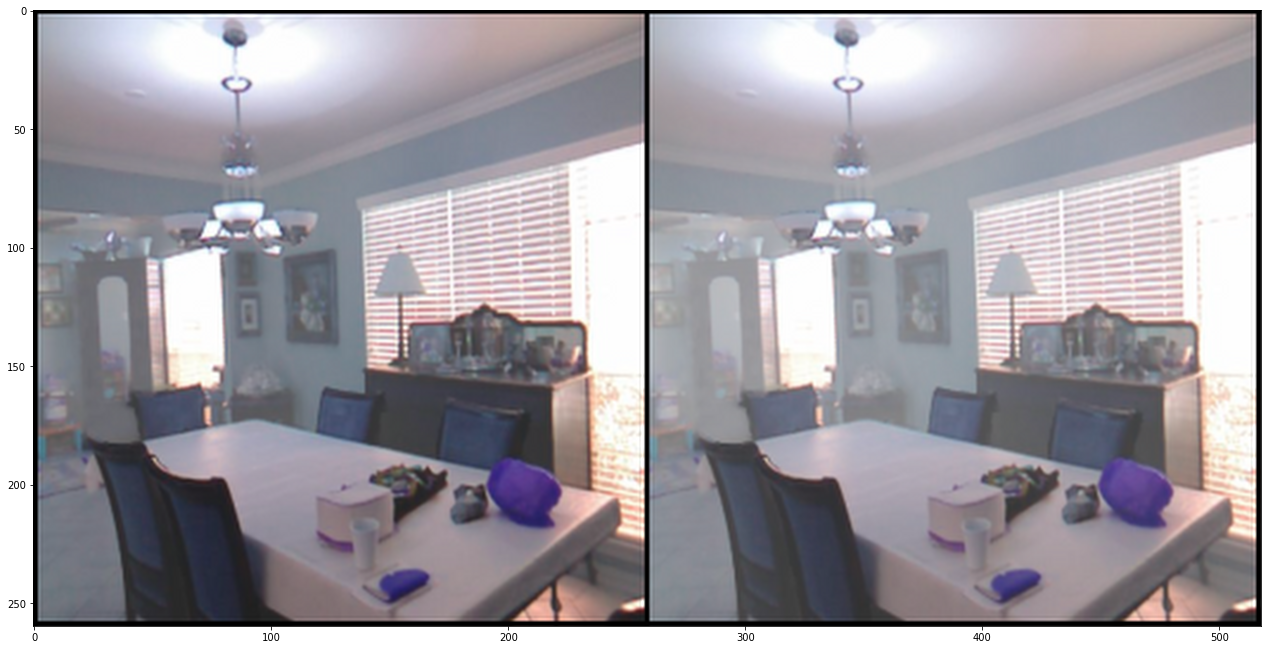

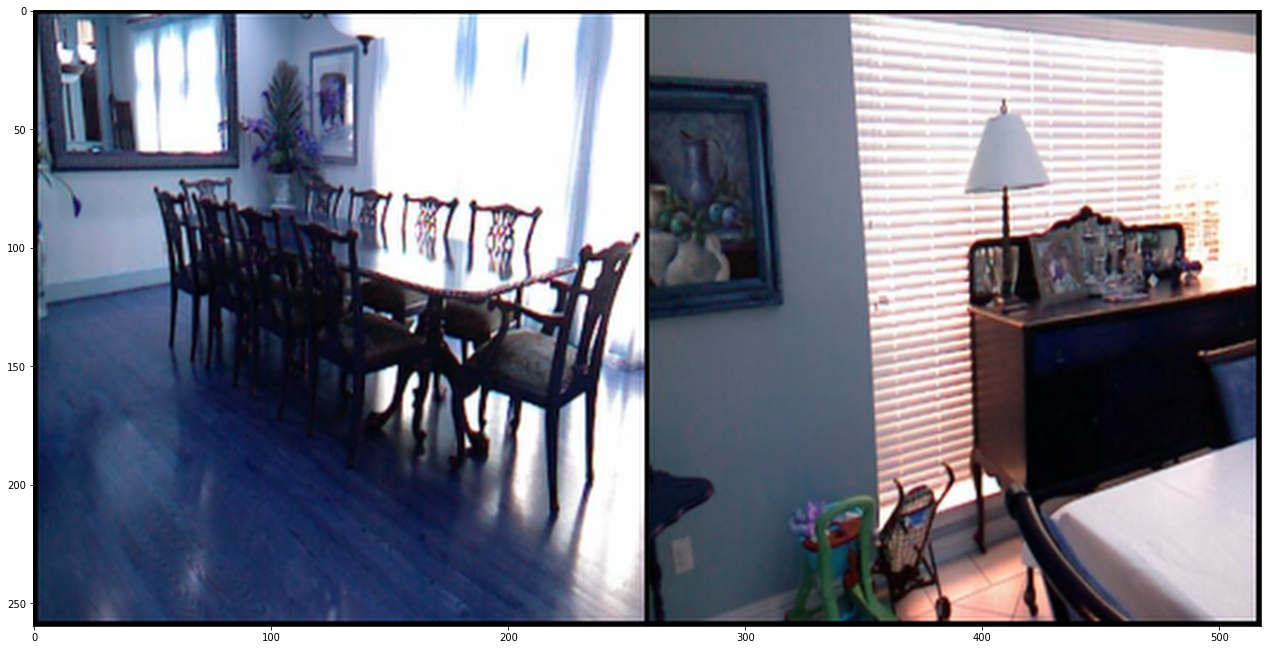

In [15]:
plot_image_grid(hazed_images[10:12])
plot_image_grid(clear_images[10:12])

In [16]:
model = DEHAZE_SGID_PFF(img_channels=3, t_channels=1, n_resblock=3, n_feat=32).to(device)
model.load_state_dict(torch.load(PATH),strict=False)
model_dict = torch.load(PATH)
for key in model_dict:
  print(key,model_dict[key].shape)
# model.eval()
# print(model)

Creating Dehaze-SGID-PFF Net
Creating Pre-Dehaze-T Net
Creating Trans Net
Creating U-Net
Creating Dehaze-T Net
Creating BRB-Fusion-Module
Creating Trans Net
Creating U-Net
pre_dehaze.trans_net.unet_body.inBlock.0.0.weight torch.Size([32, 3, 5, 5])
pre_dehaze.trans_net.unet_body.inBlock.0.0.bias torch.Size([32])
pre_dehaze.trans_net.unet_body.inBlock.1.conv1.weight torch.Size([32, 32, 5, 5])
pre_dehaze.trans_net.unet_body.inBlock.1.conv1.bias torch.Size([32])
pre_dehaze.trans_net.unet_body.inBlock.1.conv2.weight torch.Size([32, 32, 5, 5])
pre_dehaze.trans_net.unet_body.inBlock.1.conv2.bias torch.Size([32])
pre_dehaze.trans_net.unet_body.inBlock.2.conv1.weight torch.Size([32, 32, 5, 5])
pre_dehaze.trans_net.unet_body.inBlock.2.conv1.bias torch.Size([32])
pre_dehaze.trans_net.unet_body.inBlock.2.conv2.weight torch.Size([32, 32, 5, 5])
pre_dehaze.trans_net.unet_body.inBlock.2.conv2.bias torch.Size([32])
pre_dehaze.trans_net.unet_body.inBlock.3.conv1.weight torch.Size([32, 32, 5, 5])
pre_de

In [17]:
def numpy2tensor(input, rgb_range=1.):
    img = np.array(input).astype('float64')
    np_transpose = np.ascontiguousarray(img.transpose((2, 0, 1)))  # HWC -> CHW
    tensor = torch.from_numpy(np_transpose).float()  # numpy -> tensor
    tensor.mul_(rgb_range / 255).to(device)  # (0,255) -> (0,1)
    tensor = tensor.unsqueeze(0).to(device)
    return tensor

def tensor2numpy(tensor, rgb_range=1.):
        rgb_coefficient = 255 / rgb_range
        img = tensor.mul(rgb_coefficient).clamp(0, 255).round()
        img = img[0].data
        img = np.transpose(img.cpu().numpy(), (1, 2, 0)).astype(np.uint8)
        return img


In [18]:
img_tensor = numpy2tensor(hazed_images[10]).to(device)
_, res, _, _, _ = model(img_tensor)

In [19]:
output_img = tensor2numpy(res)

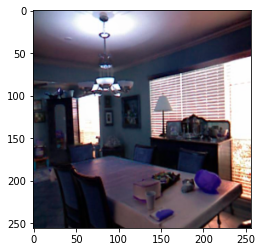

In [20]:
plt.imshow(output_img)

In [21]:
def quality_evaluation(recons_images, test_images, metric='PSNR', display=True):
    recons = []
    for i in range(len(recons_images)):
        metric_recons = 0
        if metric == 'PSNR':
            metric_recons = cv2.PSNR(recons_images[i], test_images[i])
        elif metric == 'SSIM':
            metric_recons = ssim(recons_images[i], test_images[i], multichannel=True)
        elif metric == 'UQI':
            metric_recons = sewar.full_ref.uqi(recons_images[i], test_images[i], ws=8)
        recons.append(metric_recons)
    if display:
        print(metric)
        print(np.array(recons).mean())
    return np.array(recons).mean()

In [26]:
class Img_Enhancing_Env(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, clear_images, hazed_images, model, model_dict, target_score):
        super(Img_Enhancing_Env, self).__init__()
        self.clear_images = clear_images
        self.hazed_images = hazed_images
        self.test_images = np.array(clear_images)
        self.target_score = target_score
        self.model = model
        self.model_dict = model_dict
        self.init_weights = self.get_weights()
        self.init_weights_shape = self.init_weights.shape 
        self.reward_range = (-15, 5)
        self.psnr = 0
        self.h = len(clear_images[0][0])
        self.current_step = 0
        self.action_size = self.get_action_size()
        self.action_space = spaces.Box(low=0.999, high=1.001, shape=(self.action_size,), dtype=np.float32)
        self.observation_space = spaces.Box(0, self.target_score, shape=(1,),dtype=np.float32)
    
    def step(self, action):
        
        
        key1 = 'dehaze.trans_net.unet_body.outBlock.3.weight'
        val = self.model_dict[key1].to(device)
        
        weights_flatten = self.flatten(self.init_weights)
        updated_weights = torch.mul(weights_flatten,torch.from_numpy(action).to(device))
        deflatten_weights = self.deflatten(updated_weights,self.init_weights_shape)
        self.model_dict[key1] = deflatten_weights
        model.load_state_dict(model_dict)
        dehazed_images = []
        print(len(self.test_images))
        for i in range(len(self.test_images)):
            img_tensor = numpy2tensor(self.test_images[i]).to(device)
            _, res, _, _, _ = model(img_tensor)
            res = tensor2numpy(res)
            dehazed_images.append(res)
            #psnr_ = quality_evaluation(dehazed_images[i], self.test_images[i], metric='PSNR', display=True)
              
        
        psnr = quality_evaluation(dehazed_images, self.test_images, metric='PSNR', display=False)
        reward = 1.25 * (psnr - self.target_score) + 5
        reward = self.reward_range[1] if reward > self.reward_range[1] else reward
        reward = self.reward_range[0] if reward < self.reward_range[0] else reward
        done = psnr >= self.target_score - 1
        self.current_step += 1
        self.psnr = psnr
        print(self.current_step, reward, psnr)
        obs = np.array([psnr])
        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        print('reset')
        self.psnr = 0
        self.current_step = 0
        obs = np.array([0])
        return obs

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        print(f'Step: {self.current_step}')
        print(f'PSNR: {self.psnr}')
        
    def print_s(self):
            print(self.action_size)
            
    def get_weights(self):
        key1 = 'dehaze.trans_net.unet_body.outBlock.3.weight'
        val = self.model_dict[key1].to(device)
        return val
    
    def flatten(self, weights):       
        flatten_t = torch.flatten(weights)
        return flatten_t
        
    def deflatten(self, arr,shape):
        arr = arr.reshape(shape)
        return arr
        
    def get_action_size(self):
        t = self.init_weights.shape
        p = 1
        for i in t:
            p = p * i
        return p
        
        

# model_y = load_models('pretrained models/celeba_y/', LATENT_DIM, SHAPE)
# model_u = load_models('pretrained models/celeba_u/', LATENT_DIM, SHAPE)
# model_v = load_models('pretrained models/celeba_v/', LATENT_DIM, SHAPE)
#env = DummyVecEnv([lambda: Img_Enhancing_Env(clear_images, noise_images, [model_y, model_u, model_v], 30)])

In [27]:

#env = DummyVecEnv([lambda: Img_Enhancing_Env(clear_copy, hazed_images, model1, 30)])
env = Img_Enhancing_Env(clear_copy, hazed_images, model,model_dict,30)
env.print_s()
# env.action_space.sample()
#x=env.flatten(env.init_weights)

800


In [28]:
rl_model = SAC('MlpPolicy', env, verbose=1, learning_rate=0.001)
rl_model.learn(total_timesteps=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
reset
500
1 -5.192740728715934 21.845807417027252
500
2 -5.193884784514138 21.84489217238869
500
3 -5.192402072526022 21.846078341979183
500
4 -5.194018134510205 21.844785492391836
500
5 -5.191276925653977 21.84697845947682
500
6 -5.191150177332764 21.84707985813379
500
7 -5.194328358295932 21.844537313363254
500
8 -5.193805050131379 21.844955959894897
500
9 -5.194183528016474 21.84465317758682
500
10 -5.192325657320133 21.846139474143893
500
11 -5.191703540608078 21.84663716751354
500
12 -5.19349482767845 21.84520413785724
500
13 -5.191617510700581 21.846705991439535
500
14 -5.193611587452786 21.84511073003777
500
15 -5.193776451682325 21.84497883865414
500
16 -5.192750110072048 21.84579991194236
500
17 -5.193735284281784 21.845011772574573
500
18 -5.191904084691409 21.846476732246874
500
19 -5.191132805794529 21.847093755364376
500
20 -5.192722114486381 21.845822308410895
500
21 -5.19326639

KeyboardInterrupt: ignored